<a href="https://colab.research.google.com/github/jananilakshminarayanan/DA-DS-projects/blob/main/toxic_comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Toxic Comments Classifier**
This is a 5 yr old kaggle competition where users were given a large dataset pulled from wikipedia comments labelled as toxic by human raters. There are six types of toxicities in this data: toxic, severe-toxic, obscene, threat, insult and identity-hate.

**Prob statement:** Develop a multi-headed model that is capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate. Given a text input the model has to predict whether its toxic or not and give a detailed insight into the diff sub categories of toxicity it belongs to as given in input data labels.

**Solution approach:** Since this is in essence a text classification problem, we will be using NLP technique i.e tf-idf vectorization to convert input comments to vectors. This technique takes into account not only the frequency of words or character n-grams in the text, it also takes into account the relevancy of those tokens across the dataset as a whole. The inverse document frequency reduces the weight of common tokens while boosting the weight of more unique tokens. Also this is a multilabel classification problem as each comment may belong to one or more categories.

**Step 1:** Import Necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score ,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10,5)

import warnings
warnings.filterwarnings('ignore')



**Step 2:** Load the dataset

In [ ]:
df = pd.read_csv("train.csv")

In [ ]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


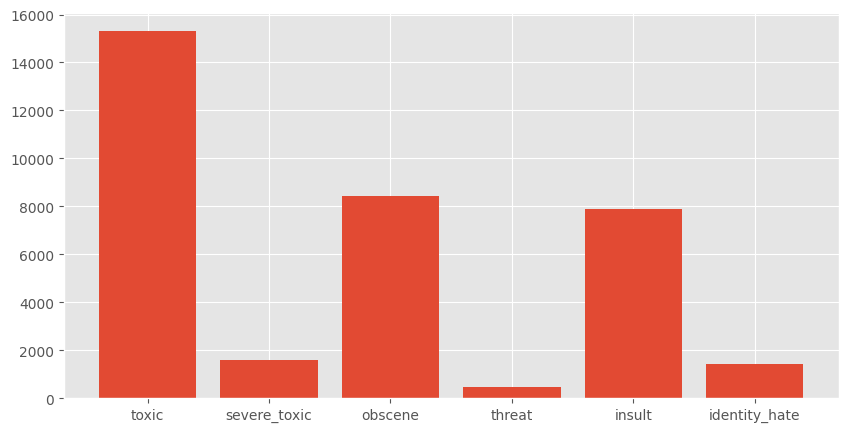

In [ ]:
cols_target = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

x= df[cols_target].sum().index
y = df[cols_target].sum()
plt.bar(x,y)
plt.show()

**Step 3:** Data Cleaning

Clean the text by removing the punctuations and converting all the abbreviations into their full forms.

In [ ]:
def  clean_text(text):
    text =  text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()#/@;:{}`+=~|.!?,*]", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r"(\W)"," ",text)
    return text

In [ ]:
df['clean_text'] = df['comment_text'].apply(lambda text: clean_text(text))


In [ ]:
# compare the clean text with original comments
df[['comment_text','clean_text']].head(10)

,comment_text,clean_text
0,Explanation\nWhy the edits made under my usern...,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,daww he matches this background colour i am se...
2,"Hey man, I'm really not trying to edit war. It...",hey man i am really not trying to edit war it ...
3,"""\nMore\nI can't make any real suggestions on ...",more i cannot make any real suggestions on im...
4,"You, sir, are my hero. Any chance you remember...",you sir are my hero any chance you remember wh...
5,"""\n\nCongratulations from me as well, use the ...",congratulations from me as well use the tool...
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,cocksucker before you piss around on my work
7,Your vandalism to the Matt Shirvington article...,your vandalism to the matt shirvington article...
8,Sorry if the word 'nonsense' was offensive to ...,sorry if the word nonsense was offensive to yo...
9,alignment on this subject and which are contra...,alignment on this subject and which are contra...


**Step 4:** split input data into train and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df[cols_target], test_size= 0.4)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)



(95742,)
(95742, 6)
(63829,)
(63829, 6)


**Step 5:** Vectorize the text using TfidfVectorizer

To understand more about Tfidf vectors go through this link

https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/

In [ ]:
vect = TfidfVectorizer(
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'w{1,}',
    ngram_range=(1, 3),
    stop_words='english',
    sublinear_tf=True)
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

**Step 6:**  Build a ML model

 As we know this is a multilabel classification problem and each comment may belong to one or more categories.  The multilabel classification can be transformed into binary classification by building a distinct model for each category. This can be accomplished by training six separate models while iterating over the categories in a loop. One simple method to accomplish this is to use OneVsRestClassifier, which automatically fits one classifier per class. To build the model, we will wrap a Multinomial Naive Bayes Classifier in OneVsRestClassifier.

To know more about OneVsRestClassifier go through this link

https://www.geeksforgeeks.org/one-vs-rest-strategy-for-multi-class-classification/

In [ ]:
# create MultinomialNB model
model = OneVsRestClassifier(MultinomialNB())

# Fit the model with training data
model.fit(X_train,y_train)

# Make predictions on test data
y_pred = model.predict(X_test)

In [ ]:
# create logreg model
model = OneVsRestClassifier(LogisticRegression(C=5,multi_class='multinomial',solver = 'newton-cg'))

# Fit the model with training data
model.fit(X_train,y_train)

# Make predictions on test data
y_pred = model.predict(X_test)

**Step 7:**  Evaluate the Model

Create a Confusion Matrix for each category and analyse results

In [ ]:
cfs = []
for i in range(6):
    cf = np.asarray(confusion_matrix(y_test[cols_target[i]], y_pred[:,i]))
    cfs.append(cf)

In [ ]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names,c,fontsize=14):
  df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names,)
  heatmap = sns.heatmap(df_cm, annot=True,cmap=c, fmt="d", cbar=False, ax=axes)
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
  axes.set_ylabel('True label')
  axes.set_xlabel('Predicted label')
  axes.set_title("Confusion Matrix for the class - " + class_label)


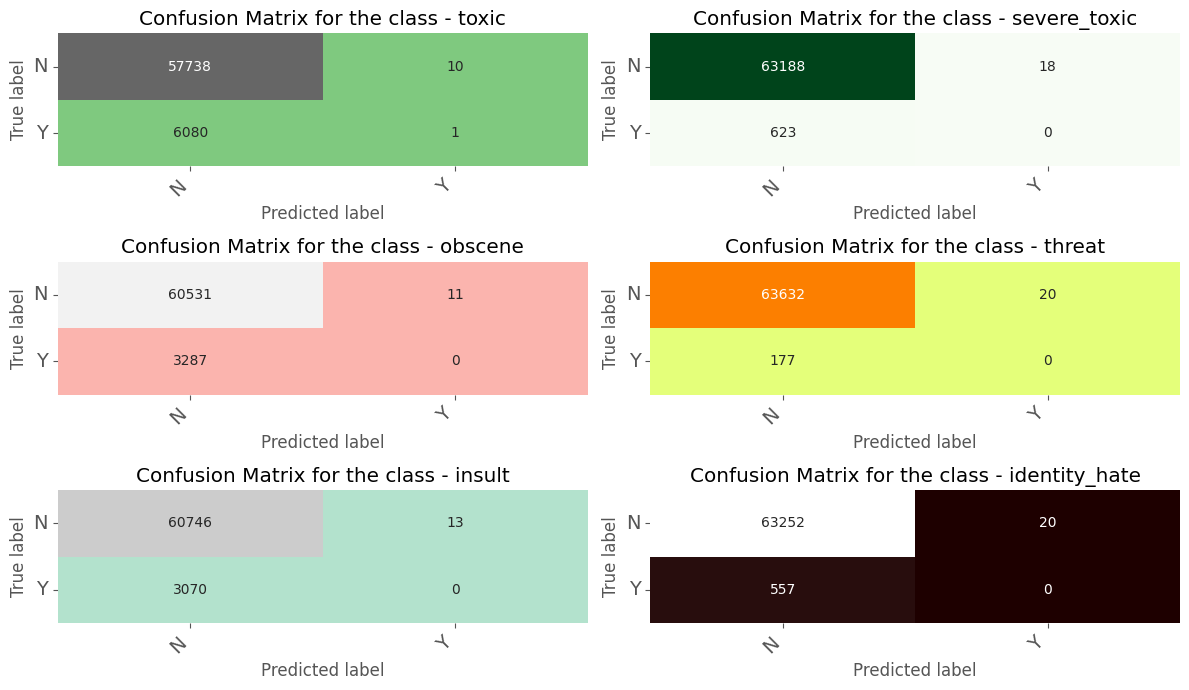

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(12, 7))

cmaps = ['Accent','Greens','Pastel1','Wistia','Pastel2','pink']

for axes, cfs_matrix, label, i in zip(ax.flatten(), cfs, cols_target,range(6)):

    c = cmaps[i]

    print_confusion_matrix(cfs_matrix, axes, label,["N", "Y"],c,14)


fig.tight_layout()

plt.show()


**classification report:**

In [ ]:
cr = pd.DataFrame(classification_report(y_test,y_pred, target_names=cols_target,output_dict=True)).T
cr['support'] = cr.support.apply(int)
cr.style.background_gradient(cmap='Pastel1')


,precision,recall,f1-score,support
toxic,0.090909,0.000164,0.000328,6081
severe_toxic,0.000000,0.000000,0.000000,623
obscene,0.000000,0.000000,0.000000,3287
threat,0.000000,0.000000,0.000000,177
insult,0.000000,0.000000,0.000000,3070
identity_hate,0.000000,0.000000,0.000000,557
micro avg,0.010753,0.000072,0.000144,13795
macro avg,0.015152,0.000027,0.000055,13795
weighted avg,0.040074,0.000072,0.000145,13795
samples avg,0.000005,0.000016,0.000008,13795


**Step 8:**  Use the Model built to predict toxicity of user comments

In [ ]:
def make_test_predictions(df,classifier):
  df['comment_text'] = df['comment_text'].apply(clean_text)
  X_test = df['comment_text']
  X_test_transformed = vect.transform(X_test)
  #print(X_test_transformed)
  y_test_pred = classifier.predict_proba(X_test_transformed)
  print(y_test_pred[0])
  a = np.array(y_test_pred[0])
  #a = y_test_pred[0] * 100
  #print(a)
  plt.bar(cols_target, y_test_pred[0]*100)
  plt.ylim((0,100))

  result =  sum(y_test_pred[0])
  if result >= 0.5:
    plt.title('The comment is Toxic')
  else :
    plt.title('The comment is Non Toxic')


**Step 9:**  Give random user input and test the model built

[0.09632136 0.01000606 0.05320549 0.00283052 0.04954983 0.00850202]


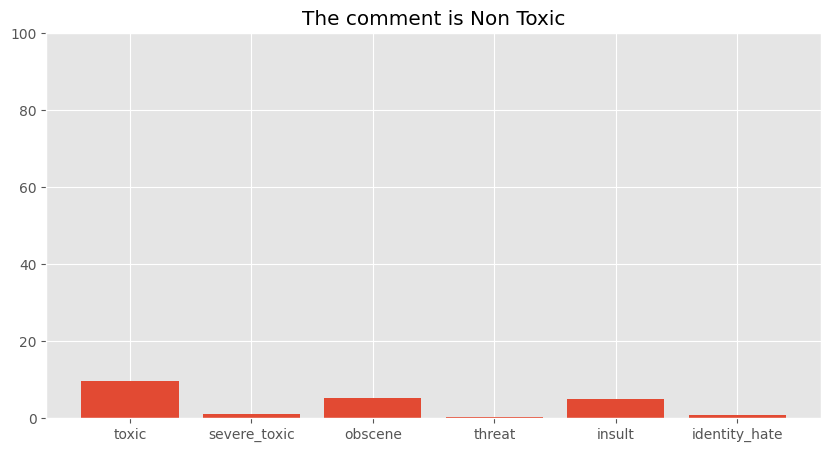

In [ ]:
comment_text = "stupid bitch"

comment ={'id':[1],'comment_text':[comment_text]}

comment = pd.DataFrame(comment)

make_test_predictions(comment,model)


In [ ]:
dft = pd.read_csv("test.csv")
dft.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
dft['clean_text'] = dft['comment_text'].apply(lambda text: clean_text(text))


In [ ]:
# compare the clean text with original comments
dft[['comment_text','clean_text']].head(10)

,comment_text,clean_text
0,Yo bitch Ja Rule is more succesful then you'll...,yo bitch ja rule is more succesful then you wi...
1,== From RfC == \n\n The title is fine as it is...,from rfc the title is fine as it is imo
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",sources zawe ashton on lapland
3,":If you have a look back at the source, the in...",if you have a look back at the source the info...
4,I don't anonymously edit articles at all.,i do not anonymously edit articles at all
5,Thank you for understanding. I think very high...,thank you for understanding i think very highl...
6,Please do not add nonsense to Wikipedia. Such ...,please do not add nonsense to wikipedia such e...
7,:Dear god this site is horrible.,dear god this site is horrible
8,""" \n Only a fool can believe in such numbers. ...",only a fool can believe in such numbers t...
9,== Double Redirects == \n\n When fixing double...,double redirects when fixing double redir...


In [ ]:
Xt_test = vect.transform(dft['clean_text'])

In [ ]:
yt_pred = model.predict_proba(Xt_test)

In [ ]:
yt_pred

array([[0.08833008, 0.00695204, 0.04705629, 0.00170117, 0.04426564,
        0.00651009],
       [0.09541715, 0.00992847, 0.05247137, 0.00301704, 0.04933795,
        0.00863929],
       [0.10718139, 0.01076056, 0.05970117, 0.00265921, 0.05614771,
        0.00881501],
       ...,
       [0.08984978, 0.00716341, 0.04799971, 0.00174273, 0.04514837,
        0.00662932],
       [0.08817458, 0.00693135, 0.04696024, 0.00169737, 0.04417574,
        0.00649851],
       [0.10146551, 0.00931146, 0.05554713, 0.00228856, 0.05221157,
        0.00788604]])

In [ ]:
dfy = pd.DataFrame(yt_pred, columns = [cols_target])

print(dfy.head())

      toxic severe_toxic   obscene    threat    insult identity_hate
0  0.088330     0.006952  0.047056  0.001701  0.044266      0.006510
1  0.095417     0.009928  0.052471  0.003017  0.049338      0.008639
2  0.107181     0.010761  0.059701  0.002659  0.056148      0.008815
3  0.107181     0.010761  0.059701  0.002659  0.056148      0.008815
4  0.095417     0.009928  0.052471  0.003017  0.049338      0.008639


In [ ]:
df_result = pd.concat([dft, dfy], axis = 1, join = 'inner')
df_result.head()

,id,comment_text,clean_text,"(toxic,)","(severe_toxic,)","(obscene,)","(threat,)","(insult,)","(identity_hate,)"
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,yo bitch ja rule is more succesful then you wi...,0.088330,0.006952,0.047056,0.001701,0.044266,0.006510
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,from rfc the title is fine as it is imo,0.095417,0.009928,0.052471,0.003017,0.049338,0.008639
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",sources zawe ashton on lapland,0.107181,0.010761,0.059701,0.002659,0.056148,0.008815
3,00017563c3f7919a,":If you have a look back at the source, the in...",if you have a look back at the source the info...,0.107181,0.010761,0.059701,0.002659,0.056148,0.008815
4,00017695ad8997eb,I don't anonymously edit articles at all.,i do not anonymously edit articles at all,0.095417,0.009928,0.052471,0.003017,0.049338,0.008639


In [ ]:
df_result.tail(10)

,id,comment_text,clean_text,"(toxic,)","(severe_toxic,)","(obscene,)","(threat,)","(insult,)","(identity_hate,)"
153154,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,shame on you all you want to speak about ga...,0.107181,0.010761,0.059701,0.002659,0.056148,0.008815
153155,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,mel gibson is a nazi bitch who makes shitty mo...,0.101466,0.009311,0.055547,0.002289,0.052212,0.007886
153156,fffb5451268fb5ba,""" \n\n == Unicorn lair discovery == \n\n Suppo...",unicorn lair discovery supposedly a u...,0.092523,0.007576,0.049682,0.001835,0.046722,0.006866
153157,fffc2b34bbe61c8d,:Disagree. Soviet railways need their own arti...,disagree soviet railways need their own articl...,0.092523,0.007576,0.049682,0.001835,0.046722,0.006866
153158,fffc489742ffe69b,This idiot can't even use proper grammar when ...,this idiot cannot even use proper grammar when...,0.107181,0.010761,0.059701,0.002659,0.056148,0.008815
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",i totally agree this stuff is nothing but t...,0.095417,0.009928,0.052471,0.003017,0.049338,0.008639
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,throw from out field to home plate does i...,0.092523,0.007576,0.049682,0.001835,0.046722,0.006866
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",okinotorishima categories i see your ...,0.089850,0.007163,0.048000,0.001743,0.045148,0.006629
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",one of the founding nations of the eu ge...,0.088175,0.006931,0.046960,0.001697,0.044176,0.006499
153163,ffffce3fb183ee80,""" \n :::Stop already. Your bullshit is not wel...",stop already your bullshit is not welcome h...,0.101466,0.009311,0.055547,0.002289,0.052212,0.007886
